In [14]:
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn import linear_model
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
jordan = pd.read_csv("jordan_career.csv")
lebron = pd.read_csv("lebron_career.csv")

###
pd.set_option('display.max_rows', jordan.shape[0]+1)
pd.set_option('display.max_rows', lebron.shape[0]+1)
pd.set_option('display.max_columns', jordan.shape[1]+1)
pd.set_option('display.max_columns', lebron.shape[1]+1)
###

jordan.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 
lebron.drop(["game", "date", "team", "opp", "minus_plus"], axis=1, inplace=True) 

jordan["threep"] = jordan["threep"].fillna(0)
lebron["threep"] = lebron["threep"].fillna(0)

jordan["ftp"] = jordan["ftp"].fillna(0)
lebron["ftp"] = lebron["ftp"].fillna(0)

jordan["result"] = [int(res.split(" ")[1][1:-1]) for res in jordan["result"]]
lebron["result"] = [int(res.split(" ")[1][1:-1]) for res in lebron["result"]]

t_age = lambda a, b: a + b / 365
jordan["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in jordan["age"]]
lebron["age"] = [t_age(*[int(i) for i in age.split("-")]) for age in lebron["age"]]

t_time = lambda a, b: a + b / 60
jordan["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in jordan["mp"]]
lebron["mp"] = [t_time(*[int(i) for i in m.split(":")]) for m in lebron["mp"]]

In [3]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

js = standarize(jordan)
ls = standarize(lebron)

In [4]:
jsize = jordan.shape[0]
X_jordan = jordan[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = jordan["game_score"]
X_train_j = X_jordan[:int(jsize*0.6)]
y_train_j = y_jordan[:int(jsize*0.6)]
X_test_j = X_jordan[int(jsize*0.6):int(jsize*0.8)]
y_test_j = y_jordan[int(jsize*0.6):int(jsize*0.8)]
X_cross_j = X_jordan[int(jsize*0.8):]
y_cross_j = y_jordan[int(jsize*0.8):]

lsize = lebron.shape[0]
X_lebron = lebron[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = lebron["game_score"]
X_train_l = X_lebron[:int(jsize*0.6)]
y_train_l = y_lebron[:int(jsize*0.6)]
X_test_l = X_lebron[int(jsize*0.6):int(jsize*0.8)]
y_test_l = y_lebron[int(jsize*0.6):int(jsize*0.8)]
X_cross_l = X_lebron[int(jsize*0.8):]
y_cross_l = y_lebron[int(jsize*0.8):]

In [5]:
regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print ('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)

print ('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print ('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print ('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print ('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))


Coefs (per dim)  [ 0.04581011  0.00316263 -0.02762215  0.34371023 -0.73175504 -1.86309188
  0.07300259 -0.06799796 -0.22033934  0.30467866 -0.38266728  0.18582104
  0.37499931 -0.03488572  0.34011358  0.69922455  1.01041767  0.72456767
 -1.01206531  1.06510171]  and intercept:  -0.561635467854682

Training Score: 0.9967889565452203
Testing Score: 0.9963052176912673

Training MSE:  0.2544597185359222
Testing MSE:  0.24239841607495954


In [6]:
jsize = js.shape[0]
X_jordan = js[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = js["game_score"]
X_train_j = X_jordan[:int(jsize*0.6)]
y_train_j = y_jordan[:int(jsize*0.6)]
X_test_j = X_jordan[int(jsize*0.6):int(jsize*0.8)]
y_test_j = y_jordan[int(jsize*0.6):int(jsize*0.8)]
X_cross_j = X_jordan[int(jsize*0.8):]
y_cross_j = y_jordan[int(jsize*0.8):]

lsize = ls.shape[0]
X_lebron = ls[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = ls["game_score"]
X_train_l = X_lebron[:int(jsize*0.6)]
y_train_l = y_lebron[:int(jsize*0.6)]
X_test_l = X_lebron[int(jsize*0.6):int(jsize*0.8)]
y_test_l = y_lebron[int(jsize*0.6):int(jsize*0.8)]
X_cross_l = X_lebron[int(jsize*0.8):]
y_cross_l = y_lebron[int(jsize*0.8):]

In [7]:
regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
print ('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print ('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print ('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print ('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
print ('Testing R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))


Training Score: 0.9967889565452204
Testing Score: 0.9963052176912673

Training MSE:  0.002827159144216972
Testing MSE:  0.0026931527806955623
Testing R2 score:  0.9963052176912673


<IPython.core.display.Javascript object>


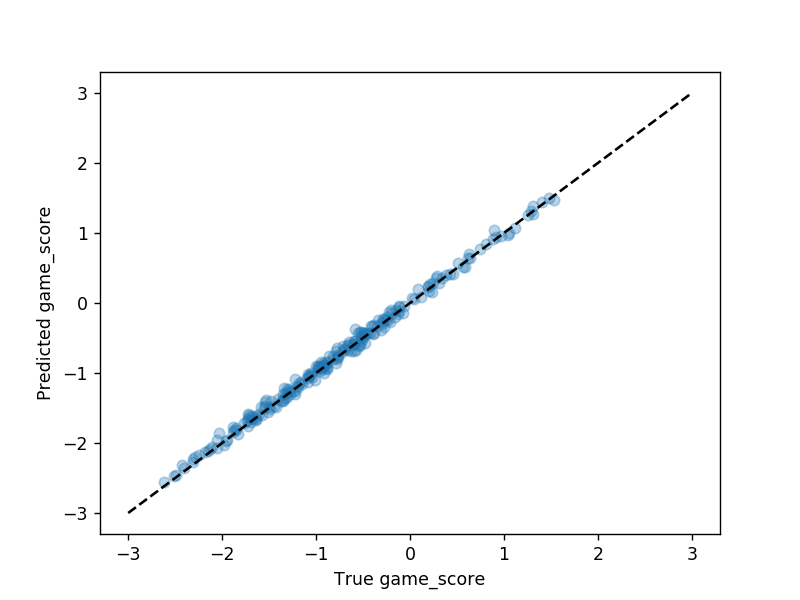

Text(0, 0.5, 'Predicted game_score')

In [12]:
# Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha = 0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')

In [22]:
js

,age,result,mp,fg,fga,fgp,three,threeatt,threep,ft,fta,ftp,orb,drb,trb,ast,stl,blk,tov,pts,game_score
0,-1.520,0.869,0.305,-1.666,-1.161,-1.680,-0.559,-0.946,-0.608,-0.205,-0.255,0.246,-0.385,0.129,-0.074,0.641,-0.208,3.132,1.311,-1.448,-1.153
1,-1.519,-0.536,-0.746,-0.882,-1.666,1.096,-0.559,-0.946,-0.608,-0.450,-0.687,0.926,1.001,-1.038,-0.406,-0.094,-0.208,0.165,0.157,-0.936,-0.426
2,-1.518,0.088,-0.746,0.425,0.187,0.425,-0.559,-0.946,-0.608,1.022,1.040,0.193,0.308,-1.038,-0.737,-0.094,2.207,1.154,0.157,0.705,0.997
3,-1.518,0.010,-0.396,-0.882,-0.318,-1.055,-0.559,-0.946,-0.608,0.531,0.176,0.926,0.308,-1.038,-0.737,-0.094,0.395,0.165,1.888,-0.525,-0.921
4,-1.517,-1.629,-0.921,-1.143,-1.329,-0.264,-0.559,-0.946,-0.608,-0.941,-0.903,-0.263,1.001,-1.038,-0.406,-0.094,-0.812,0.165,-0.420,-1.346,-1.079
5,-1.514,-0.068,-1.972,-0.620,-0.655,-0.200,-0.559,-0.946,-0.608,0.041,0.176,-0.130,-0.385,-0.649,-0.737,-0.828,0.395,0.165,1.311,-0.525,-0.900
6,-1.513,0.791,-0.921,0.948,-0.150,1.712,-0.559,-0.946,-0.608,-0.941,-0.903,-0.263,1.694,-0.260,0.589,-0.094,0.395,1.154,1.311,0.295,0.618
7,-1.512,-0.224,0.655,-0.620,-0.150,-0.797,-0.559,-0.946,-0.608,0.531,0.824,-0.263,0.308,0.908,0.920,-0.461,-0.208,4.121,0.157,-0.320,-0.236
8,-1.511,-0.146,0.831,1.732,0.693,1.575,0.472,-0.376,2.611,0.286,0.608,-0.373,0.308,1.297,1.252,-0.461,0.395,1.154,0.734,1.526,1.482
9,-1.510,-1.941,-0.921,0.164,0.187,0.039,-0.559,-0.376,-0.608,-0.941,-1.119,0.926,-1.079,-1.038,-1.400,-1.195,-0.208,0.165,-0.997,-0.320,-0.668


### regresion with just the important/relevant attributes 

In [25]:
jsize = js.shape[0]
X_jordan = js[["fg", "fga", "fgp", "threep", "ft", "fta", "ftp", "orb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_jordan = js["game_score"]
X_train_j = X_jordan[:int(jsize*0.6)]
y_train_j = y_jordan[:int(jsize*0.6)]
X_test_j = X_jordan[int(jsize*0.6):int(jsize*0.8)]
y_test_j = y_jordan[int(jsize*0.6):int(jsize*0.8)]
X_cross_j = X_jordan[int(jsize*0.8):]
y_cross_j = y_jordan[int(jsize*0.8):]

regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print ('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)

print ('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print ('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print ('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print ('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
#print ('Testing R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

"""
# Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha = 0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')"""


Coefs (per dim)  [ 0.15808876 -0.46979194 -0.02034117 -0.0026456   0.14266515 -0.19539047
  0.00422542  0.06075372  0.09756808  0.19698916  0.17711577  0.07822361
 -0.18974264  1.0746393 ]  and intercept:  -0.010569374302693724

Training Score: 0.9964638334316585
Testing Score: 0.9957646151499331

Training MSE:  0.0031134133779098993
Testing MSE:  0.0030872017708091248


"\n# Visualization of target and predicted responses\nclf = linear_model.LinearRegression()\nclf.fit(X_train_j, y_train_j)\npredicted = clf.predict(X_cross_j)\nplt.scatter(y_cross_j, predicted, alpha = 0.3)\nplt.plot([-3, 3], [-3, 3], '--k')\nplt.axis('tight')\nplt.xlabel('True game_score')\nplt.ylabel('Predicted game_score')"

In [29]:
jsize = js.shape[0]
#X_jordan = js[["age", "result", "mp", "fgp", "three", "threeatt", "threep", "ftp", "trb"]]
X_jordan = js[["pts", "fg", "fga", "ft", "fta", "orb", "drb", "stl", "blk", "tov", "ast"]]
y_jordan = js["game_score"]
X_train_j = X_jordan[:int(jsize*0.6)]
y_train_j = y_jordan[:int(jsize*0.6)]
X_test_j = X_jordan[int(jsize*0.6):int(jsize*0.8)]
y_test_j = y_jordan[int(jsize*0.6):int(jsize*0.8)]
X_cross_j = X_jordan[int(jsize*0.8):]
y_cross_j = y_jordan[int(jsize*0.8):]

regr_jordan = linear_model.LinearRegression()
regr_jordan.fit(X_train_j, y_train_j) 

print ('\nCoefs (per dim) ', regr_jordan.coef_, ' and intercept: ', regr_jordan.intercept_)

print ('\nTraining Score:', regr_jordan.score(X_train_j, y_train_j) )
print ('Testing Score:', regr_jordan.score(X_test_j, y_test_j) )
print ('\nTraining MSE: ', np.mean((regr_jordan.predict(X_train_j) - y_train_j)**2))
print ('Testing MSE: ', np.mean((regr_jordan.predict(X_test_j) - y_test_j)**2))
#print ('Testing R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

"""
# Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha = 0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')"""


Coefs (per dim)  [ 1.05055624  0.14641381 -0.44508265  0.16250883 -0.2040799   0.10731666
  0.08301411  0.1769122   0.07866497 -0.18985719  0.1972808 ]  and intercept:  -0.011386671612374888

Training Score: 0.996424386429768
Testing Score: 0.9957843011661204

Training MSE:  0.003148144440780011
Testing MSE:  0.0030728524953158947


"\n# Visualization of target and predicted responses\nclf = linear_model.LinearRegression()\nclf.fit(X_train_j, y_train_j)\npredicted = clf.predict(X_cross_j)\nplt.scatter(y_cross_j, predicted, alpha = 0.3)\nplt.plot([-3, 3], [-3, 3], '--k')\nplt.axis('tight')\nplt.xlabel('True game_score')\nplt.ylabel('Predicted game_score')"

### lebron


Coefs (per dim)  [ 2.67726174e-03  1.52387060e-03 -5.40093762e-03  5.06615581e-01
 -4.42014988e-01 -3.96975895e-03  7.30515719e-02  2.13005257e-03
  1.25221716e-03  3.76475500e-01 -2.29265745e-01 -2.80734655e-04
  8.06900887e-02  4.29323714e-02  7.01649506e-02  2.61501585e-01
  1.67881785e-01  8.45215835e-02 -2.45059766e-01  5.75740868e-01]  and intercept:  -0.0017826886653234293

Training Score: 0.9962491314305596
Testing Score: 0.9953445557882766

Training MSE:  0.0042886716122469085
Testing MSE:  0.00387057722722744


<IPython.core.display.Javascript object>


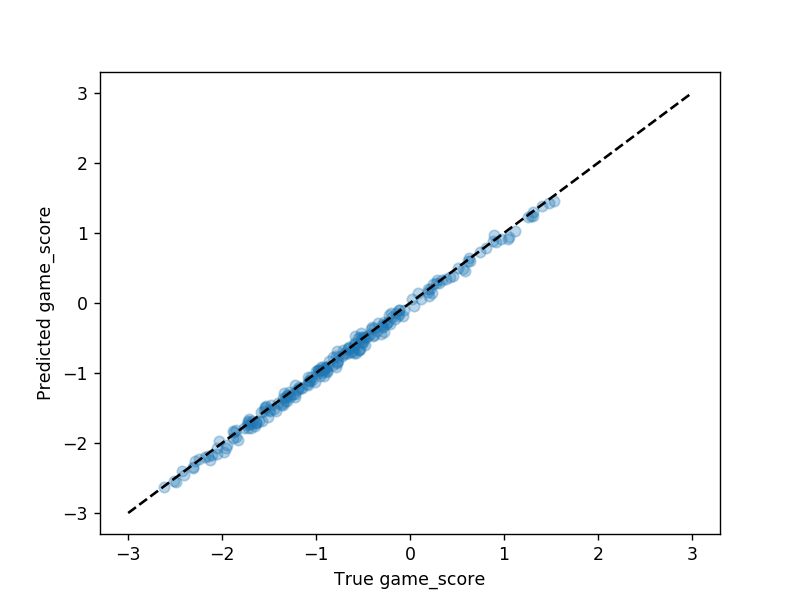

Text(0, 0.5, 'Predicted game_score')

In [31]:
lsize = ls.shape[0]
X_lebron = ls[["age", "result", "mp", "fg", "fga", "fgp", "three", "threeatt", "threep", "ft", "fta", "ftp", "orb", "drb", "trb", "ast", "stl", "blk", "tov", "pts"]]
y_lebron = ls["game_score"]
X_train_l = X_lebron[:int(jsize*0.6)]
y_train_l = y_lebron[:int(jsize*0.6)]
X_test_l = X_lebron[int(jsize*0.6):int(jsize*0.8)]
y_test_l = y_lebron[int(jsize*0.6):int(jsize*0.8)]
X_cross_l = X_lebron[int(jsize*0.8):]
y_cross_l = y_lebron[int(jsize*0.8):]

regr_lebron = linear_model.LinearRegression()
regr_lebron.fit(X_train_l, y_train_l) 

print ('\nCoefs (per dim) ', regr_lebron.coef_, ' and intercept: ', regr_lebron.intercept_)

print ('\nTraining Score:', regr_lebron.score(X_train_l, y_train_l) )
print ('Testing Score:', regr_lebron.score(X_test_l, y_test_l) )
print ('\nTraining MSE: ', np.mean((regr_lebron.predict(X_train_l) - y_train_l)**2))
print ('Testing MSE: ', np.mean((regr_lebron.predict(X_test_l) - y_test_l)**2))
#print ('Testing R2 score: ', r2_score(y_test_j, regr_jordan.predict(X_test_j)))

#Visualization of target and predicted responses
clf = linear_model.LinearRegression()
clf.fit(X_train_j, y_train_j)
predicted = clf.predict(X_cross_j)
plt.scatter(y_cross_j, predicted, alpha = 0.3)
plt.plot([-3, 3], [-3, 3], '--k')
plt.axis('tight')
plt.xlabel('True game_score')
plt.ylabel('Predicted game_score')